# Cuy Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import tensorflow as tf
import utils
import model as modellib
import visualize
from model import log
import cuy

%matplotlib inline

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
CUY_MODEL_PATH = os.path.join(MODEL_DIR, "weight_mask_rcnn_cuy_050.h5")

Using TensorFlow backend.


## Configurations

Configurations are defined in cuy.py

In [4]:
config = cuy.CuyConfig()
#CUY_DIR = os.path.join(ROOT_DIR, "dataset")
CUY_DIR = "C:\\Users\\Yeshica\\Documents\\GitHub\\datasetx4"
CUY_BW_FILE = os.path.join(CUY_DIR, "cuy_bw_augmented.txt")

## Dataset

In [5]:
# Load cuy bodyweights dataset
dataset = cuy.CuyDataset()
dataset.load_dataset(CUY_DIR,"train", CUY_BW_FILE)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 4992
Class Count: 2
  0. BG                                                
  1. cuy                                               


## Display Samples

Load and display images and masks.

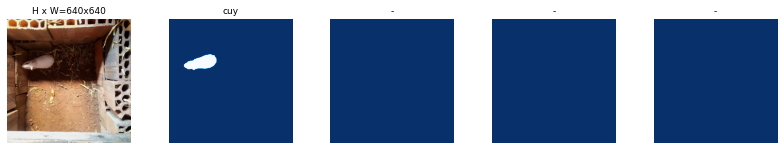

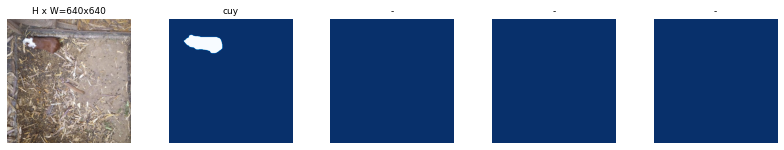

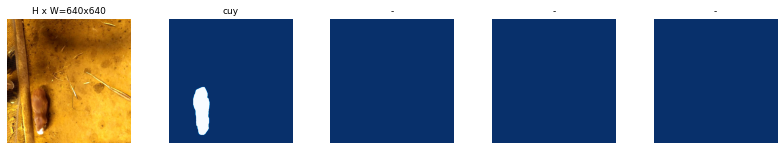

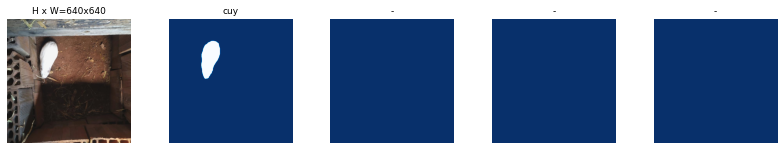

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, cuy_bw ,class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

The bounding boxes are computed from the masks, this allows us to handle bounding boxes consistently regardless of the original dataset of COCO, and it makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation. 


image_id  2008 C:\Users\Yeshica\Documents\GitHub\datasetx4\train\IMG_20210617_111228_augm_0.jpg
image                    shape: (640, 640, 3)         min:    3.00000  max:  242.00000
mask                     shape: (640, 640, 1)         min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:   47.00000  max:  393.00000


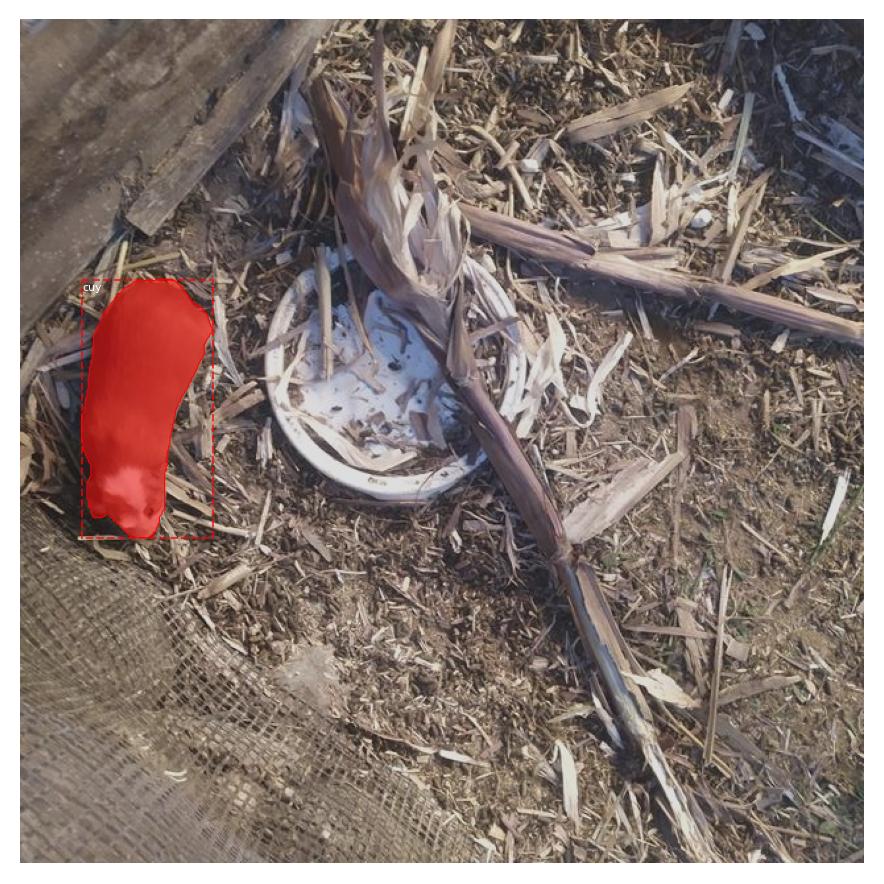

In [7]:
# Load random image and mask
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, cuy_bw ,class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negliagable for most practical purposes. This size of the mini_mask can be set in the config class

To visualize the effect of mask reisizing, and to verify the code correctness, we visualize some examples.

image                    shape: (640, 640, 3)         min:   20.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 4045.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:   80.00000  max:  272.00000
mask                     shape: (640, 640, 1)         min:    0.00000  max:    1.00000
bw                       shape: (1,)                  min:  866.97512  max:  866.97512


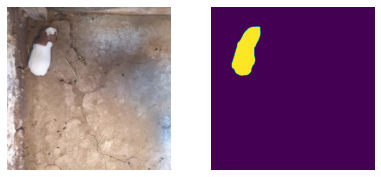

In [8]:
image_id = np.random.choice(dataset.image_ids, 1) [0]
image, image_meta, class_ids, bbox, mask, cuy_bw = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)
log("bw", cuy_bw)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

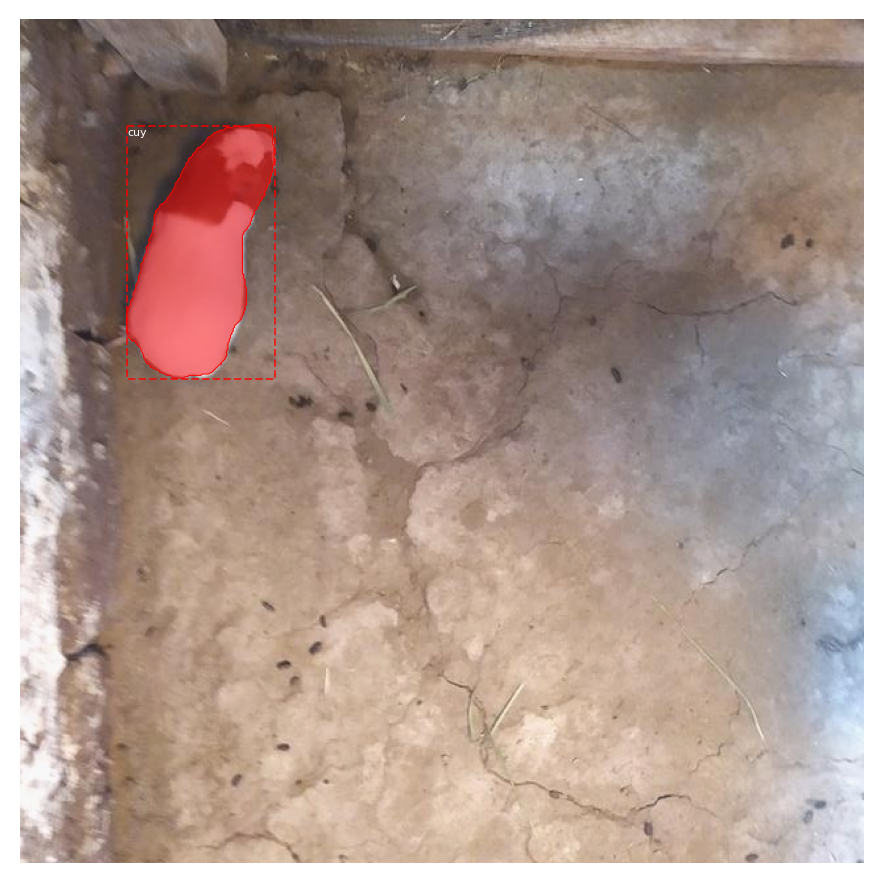

In [9]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000


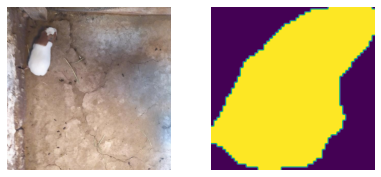

In [10]:
# Add augmentation and mask resizing
image, image_meta, class_ids, bbox, mask, cuy_bw = modellib.load_image_gt(dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1],7))])

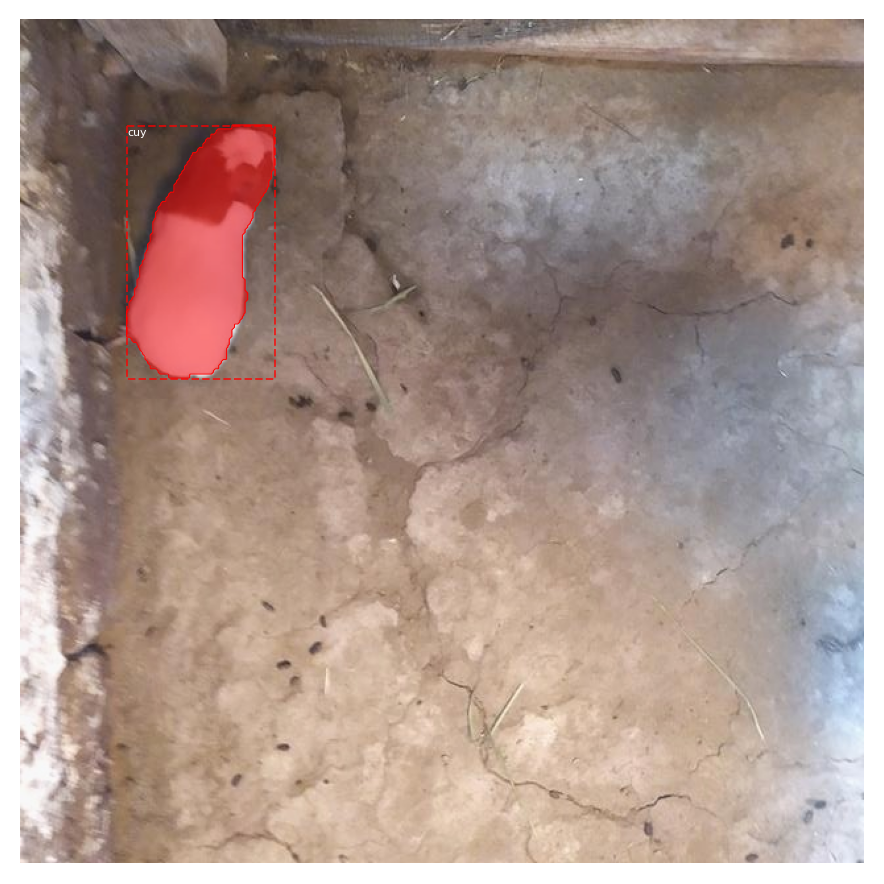

In [11]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [12]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  102300
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 76800
Anchors in Level 1: 19200
Anchors in Level 2: 4800
Anchors in Level 3: 1200
Anchors in Level 4: 300


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors:  76800  Feature map Shape: [160 160]
Level 1. Anchors:  19200  Feature map Shape: [80 80]
Level 2. Anchors:   4800  Feature map Shape: [40 40]
Level 3. Anchors:   1200  Feature map Shape: [20 20]
Level 4. Anchors:    300  Feature map Shape: [10 10]


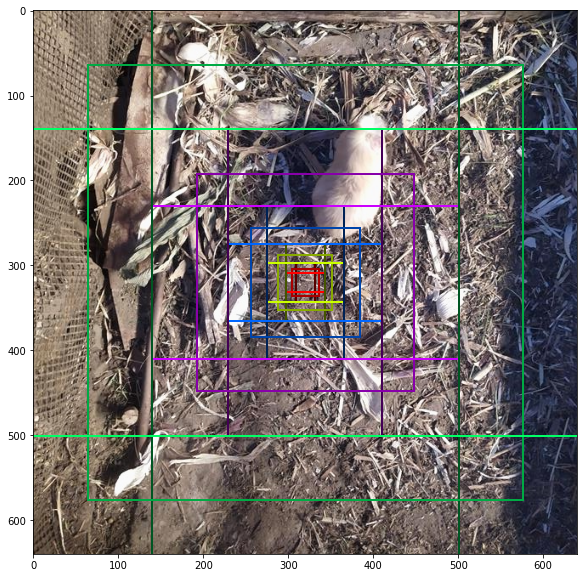

In [13]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _,_,_ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [14]:
# Create data generator
random_rois = 2000
g = modellib.data_generator_bodyweight(
    dataset, config, shuffle=True, random_rois=random_rois,
    batch_size=4,
    detection_targets=True)

In [15]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_bodyweights, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("gt_bodyweights", gt_bodyweights)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
#image_id = modellib.parse_image_meta_graph(image_meta)["image_id"][0]
#print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 100, 4)           min:    0.00000  max:  639.00000
mrcnn_class_ids          shape: (4, 100, 1)           min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (4, 100, 2, 4)        min:   -3.34356  max:    3.07692
mrcnn_mask               shape: (4, 100, 56, 56, 2)   min:    0.00000  max:    1.00000
gt_class_ids             shape: (4, 50)               min:    0.00000  max:    1.00000
gt_boxes                 shape: (4, 50, 4)            min:    0.00000  max:  607.00000
gt_masks                 shape: (4, 56, 56, 50)       min:    0.00000  max:    1.00000
gt_bodyweights           shape: (4, 50)               min:    0.00000  max: 1032.85437
rpn_match                shape: (4, 102300, 1)        min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -1.43631  max:    1.93350


anchors                  shape: (102300, 4)           min: -362.03867  max:  938.03867
refined_anchors          shape: (1, 4)                min:   17.00000  max:  607.00000
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 102044
BG                     : 68
cuy                    : 32


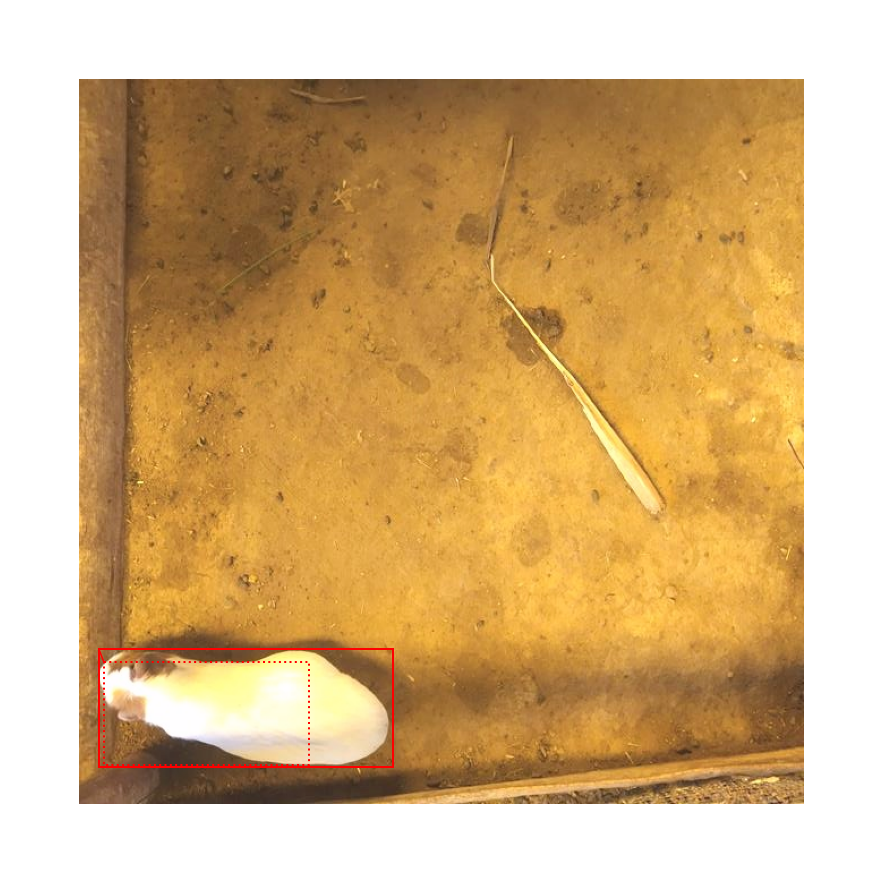

In [16]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

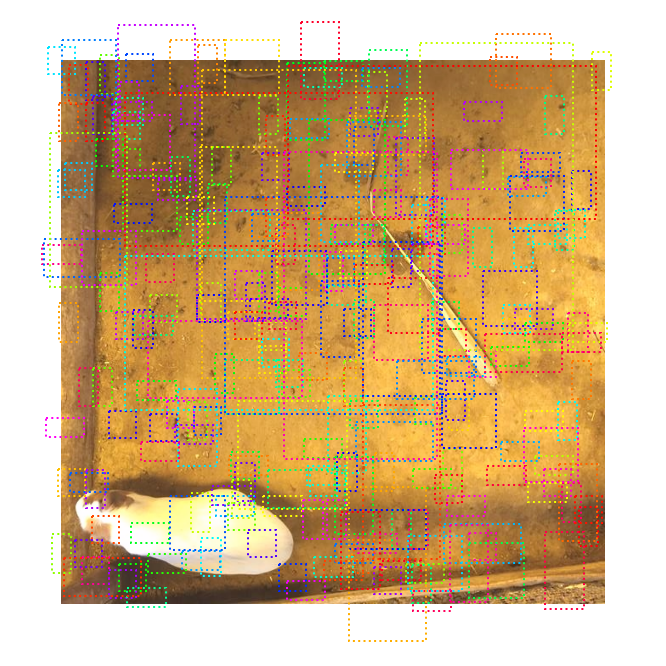

In [17]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

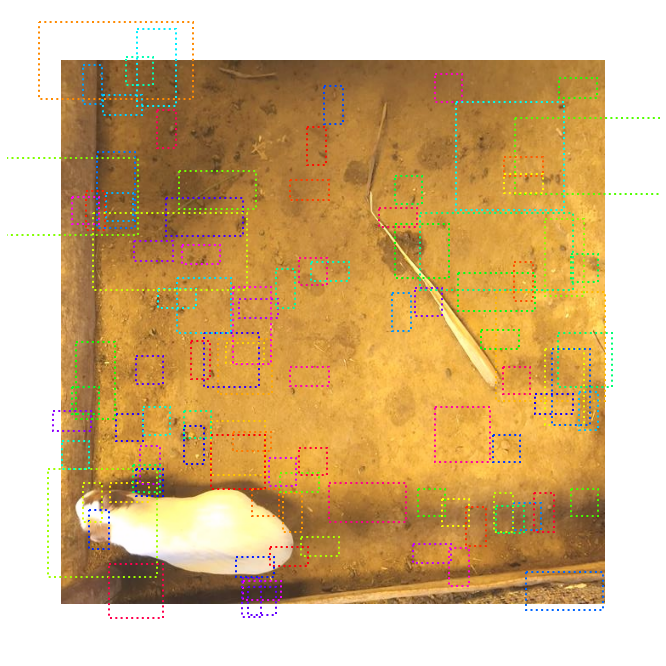

In [18]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  32
Negative ROIs:  68
Positive Ratio: 0.32
Unique ROIs: 100 out of 100


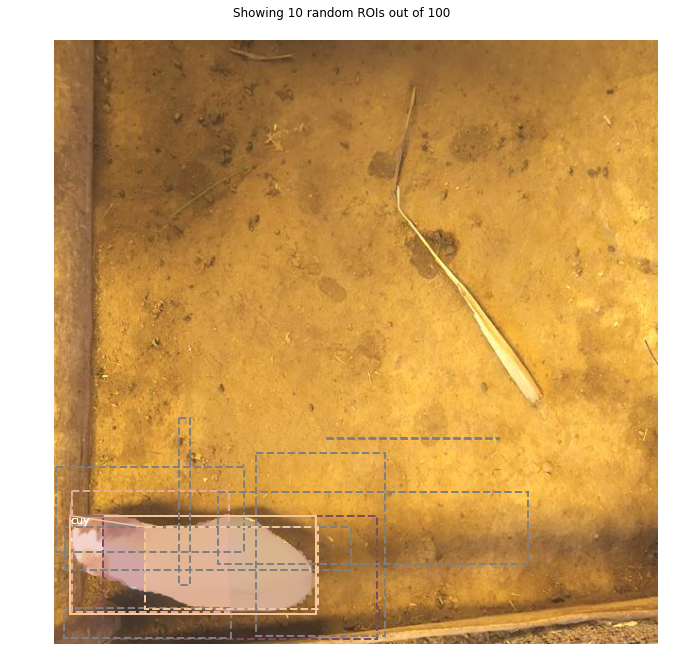

In [19]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

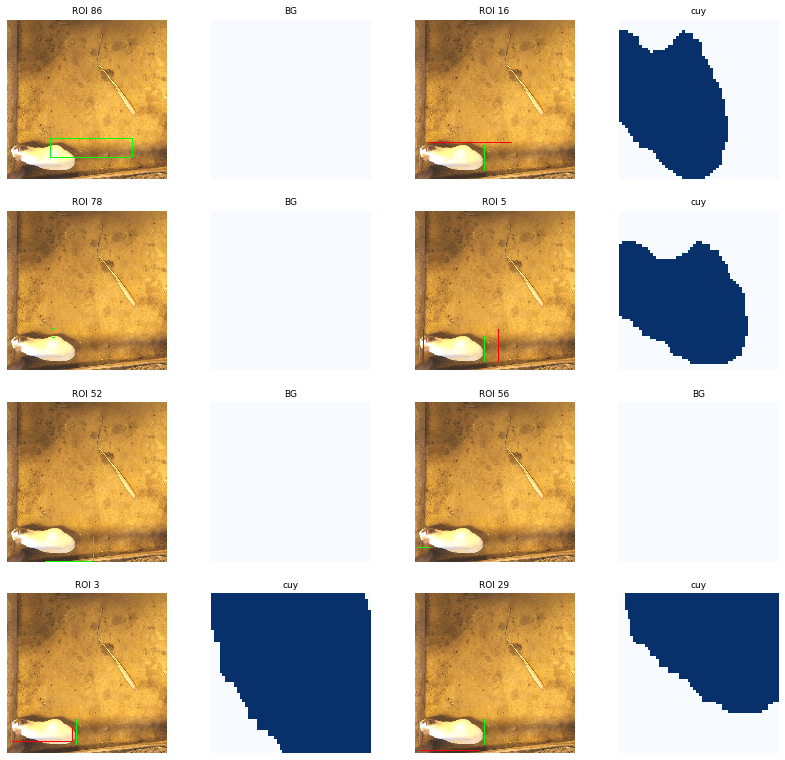

In [20]:
if random_rois:
    # Display ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [21]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator_bodyweight(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
   33  0.33
Average percent: 0.33
